In [1]:
import sent2vec
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from scipy.spatial import distance
import pandas as pd
import os
import json

In [2]:
model_path = "../bioSent2Vec_model/BioSentVec_PubMed_MIMICIII-bigram_d700.bin"

model = sent2vec.Sent2vecModel()
try:
    model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [3]:
stop_words = set(stopwords.words('english'))
def preprocess_sentence(text):
    text = text.replace('/', ' / ')
    text = text.replace('.-', ' .- ')
    text = text.replace('.', ' . ')
    text = text.replace('\'', ' \' ')
    text = text.lower()

    tokens = [token for token in word_tokenize(text) if token not in punctuation and token not in stop_words]

    return ' '.join(tokens)

In [4]:
def vectorize(input_path):
    with open(input_path) as f:
        user_text_list = f.readline()

    user_vect_text_dict = {}
    for u_txt in user_text_list:
        id, text = u_txt.split("_")
        text_list = text.split(",")
        vect = []
        for text in text_list:
            sentence = preprocess_sentence(text)
            sentence_vector = model.embed_sentence(sentence)
            vect.append(sentence_vector.tolist()[0])
        user_vect_text_dict[id] = vect
    return user_vect_text_dict
    
def write_json(dict, output_path):
    with open(output_path, "w") as outfile:
        json.dump(dict, outfile)

In [5]:
# fold0_dict = vectorize('../diseaseDiagnosis/Dataset/Fold0/TrainingSet.txt')
# write_json(fold0_dict, "user_vect_fold0.json")

In [6]:
# for n in range(400):
#     fold_dict = vectorize(f'./Dataset/Fold{n}/TrainSet.txt')
#     write_json(fold_dict, f"./Dataset/Fold{n}/TrainSet.json")

#     fold_dict = vectorize(f'./Dataset/Fold{n}/TestSet.txt')
#     write_json(fold_dict, f"./Dataset/Fold{n}/TestSet.json")

In [7]:
import numpy as np
def semantic_similarity(target_element, existing_patient_element):
    temp=0
    m = len(target_element)
    n = len(existing_patient_element)
    for x in existing_patient_element:
        temp+=max([(np.array(x) @ np.array(y))/(np.linalg.norm(x)*np.linalg.norm(y)) if np.linalg.norm(x)*np.linalg.norm(y) !=0 else 0 for y in target_element])
    return temp/max(n,m)

In [8]:
def similarity_search(patient, alpha,set_type,k):
    def similarity_search_n_folds(n):
        with open(f'Dataset/Fold{n}/{set_type}Set.json') as json_file:
            fold = json.load(json_file)

        sim_fold = []
        for  key in fold.keys():
            similarity = semantic_similarity(patient, fold[key])
            if similarity >= alpha:
                sim_fold.append(((key,n), similarity))
        if len(sim_fold)>=k:
            return sorted(sim_fold, reverse=True)
        else:
            return sorted(sim_fold, reverse=True)[:k]
    return similarity_search_n_folds

In [9]:
import multiprocess as mp
import itertools

def similar_patients(patient, alpha,n, set_type, k):
    pool = mp.Pool(4)
    results = pool.map(similarity_search(patient, alpha, set_type, k), range(n))
    pool.close()

    return dict(itertools.chain.from_iterable(results))

In [10]:
def correctly_classified(patient, similar_patients_dict, beta, set_type):
    true_predictions = [] 
    for sim_patient, n in similar_patients_dict.keys():
        with open(f'Dataset/Fold{n}/{set_type}Set.json') as json_file:
            fold = json.load(json_file)
            diagnosis = fold[sim_patient][0]
        diagnosis_similarity = semantic_similarity([diagnosis], [patient[0]])
        if diagnosis_similarity >= beta:
            true_predictions.append((sim_patient, n))
    if true_predictions:
        return 1.0
    else:
        return 0.0

In [11]:
def diagnosis_exist_in_fold(test_patient, beta):
    def diagnosis_exists_n_fold(n):
        with open(f'Dataset/Fold{n}/TrainSet.json') as json_file:
            fold = json.load(json_file)
            for targert_patient in fold.keys():
                diagnosis = fold[targert_patient][0]
                diagnosis_similarity = semantic_similarity([diagnosis], [test_patient[0]])
                if diagnosis_similarity >= beta:
                    return 1.0
                else:
                    return 0.0
    return diagnosis_exists_n_fold

In [12]:
def diagnosis_exist(test_patient, beta, n):
    pool = mp.Pool(4)
    results = pool.map(diagnosis_exist_in_fold(test_patient, beta), range(n))
    pool.close()
    if sum(results) > 0:
        return 1.0
    else:
        return 0.0

In [13]:
# prediction_label = []
# for n in range(1):
#     with open(f'Dataset/Fold{n}/TestSet.json') as json_file:
#             fold = json.load(json_file)
#             for test_patient in fold.keys():
#                 sim_patients_keys = similar_patients(fold[test_patient], 0.6, 1, 'Train', 3)
#                 prediction = correctly_classified(fold[test_patient], sim_patients_keys, 0.51, 'Train')
#                 prediction_label.append(prediction)

In [14]:
# true_label = []
# for n in range(1):
#     with open(f'Dataset/Fold{n}/TestSet.json') as json_file:
#             fold = json.load(json_file)
#             for test_patient in fold.keys():
#                 diag_exist = diagnosis_exist(fold[test_patient], 0.51, n)
#                 true_label.append(diag_exist)

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# precision = precision_score(true_label, prediction_label, average=None)
# recall = recall_score(true_label, prediction_label, average=None)
# f1 = f1_score(true_label, prediction_label, average=None)
# print(precision[0], recall[0], f1[0])

In [21]:
alpha = 0.6
beta = 0.6
N = 10

recall_list = []
precision_list = []
f1_list = []
for k in range(0,35,5):
    prediction_label = []
    for n in range(N):
        with open(f'Dataset/Fold{n}/TestSet.json') as json_file:
            fold = json.load(json_file)
            for test_patient in fold.keys():
                sim_patients_keys = similar_patients(fold[test_patient], alpha, n, 'Train', k)
                prediction = correctly_classified(fold[test_patient], sim_patients_keys, beta, 'Train')
                prediction_label.append(prediction)
    
    true_label = []
    for n in range(N):
        with open(f'Dataset/Fold{n}/TestSet.json') as json_file:
            fold = json.load(json_file)
            for test_patient in fold.keys():
                diag_exist = diagnosis_exist(fold[test_patient], beta, n)
                true_label.append(diag_exist)

    precision = precision_score(true_label, prediction_label, average=None)
    recall = recall_score(true_label, prediction_label, average=None)
    f1 = f1_score(true_label, prediction_label, average=None)
    
    recall_list.append(recall[0])
    precision_list.append(precision[0])
    f1_list.append(f1[0])

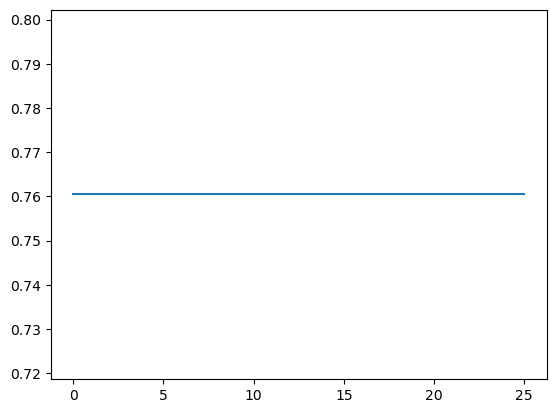

In [ ]:
import matplotlib.pyplot as plt
plt.plot( range(0,30,5), recall_list)

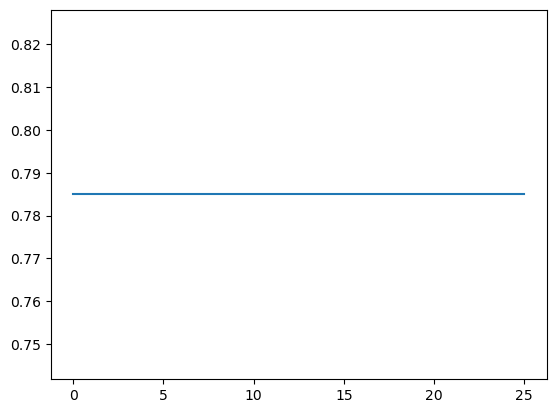

In [18]:
plt.plot(range(0,30,5), precision_list)

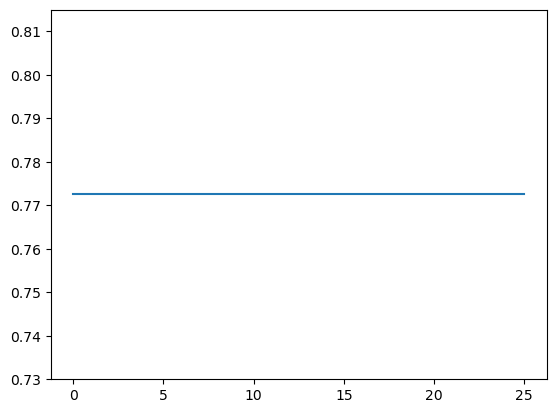

In [19]:
plt.plot(range(0,30,5), f1_list)

In [20]:
recall_list

[0.7604166666666666,
 0.7604166666666666,
 0.7604166666666666,
 0.7604166666666666,
 0.7604166666666666,
 0.7604166666666666]